# Executable simulation models of the liver
Reproduction of part of the results from the original publication using `libroadrunner`.

The publication is available from http://www.ncbi.nlm.nih.gov/pubmed/22761565.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

# global settings for plots
plt.rcParams.update({
        'axes.labelsize': 'large',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'figure.facecolor': '1.00'
    })

data_dir = '/home/mkoenig/git/glucose_whole_body/data/digitized/whole-body'

def load_glc_data(fid, sep="\t", data_dir=data_dir, show=True):
    """ Loads data from given figure/table id."""
    study = fid.split('_')[0]
    path = os.path.join(data_dir, study, '{}.csv'.format(fid))
    df = pd.read_csv(path, sep=sep, comment="#")
    if show == True:
        display(df.head())
        print(fid)
    return df

from pyexsimo import MODEL_PATH, RESULT_PATH

model_path = MODEL_PATH / 'liver_glucose.xml'

## Time courses of species

In [19]:
# load model
import sbmlsim
from sbmlsim.simulation_serial import SimulatorSerial as Simulator
from sbmlsim.timecourse import Timecourse, TimecourseSim
simulator = Simulator(model_path)
# and example timecourse
tc_sim = TimecourseSim(
    Timecourse(start=0, end=600, steps=300)
)
s = simulator.timecourses(tc_sim)

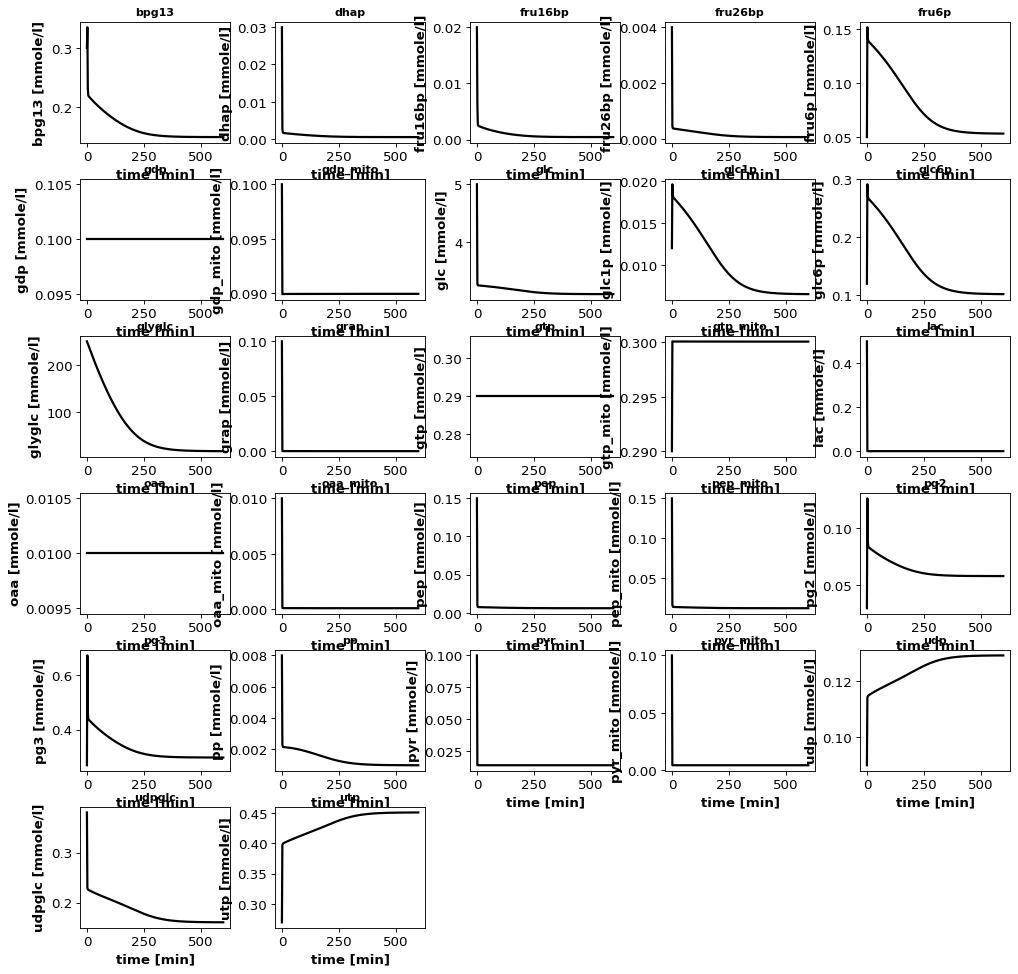

In [22]:
from matplotlib import pylab as plt
fig = plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.3, wspace=.3)

model = simulator.r.model
for k, sid in enumerate(sorted(model.getFloatingSpeciesIds())):
    plt.subplot(6, 5, k+1)
    plt.plot(s.mean['time'], s.mean['[{}]'.format(sid)], linewidth=2, color='black')
    plt.title('{}'.format(sid), fontweight='bold')
    plt.ylabel('{} [mmole/l]'.format(sid), fontweight='bold')
    plt.xlabel('time [min]'.format(sid), fontweight='bold')
    
plt.show()
fig.savefig(RESULT_PATH / 'Hepatic_glucose_timecourse.png', dpi=fig.dpi)

## Dose response curves of model (Figure 2)

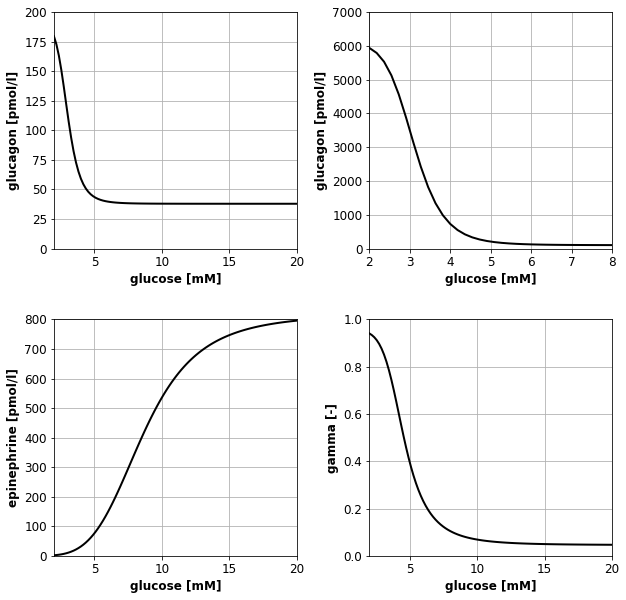

In [25]:
# calculate dose response curve of the model
import pandas as pd
import numpy as np
glc_ext_vec = np.linspace(2, 20, num=100)
hormone_keys = ["glu", "epi", "ins", "gamma"]
r = simulator.r
r.timeCourseSelections = hormone_keys + ["[glc_ext]"]

# result vectors
dose_response = {}
for key in hormone_keys:
    dose_response[key] = np.zeros_like(glc_ext_vec)

for k, glc_ext in enumerate(glc_ext_vec):
    # set glucose value
    r.resetToOrigin()
    r.setValue('[glc_ext]', glc_ext)
    s = r.simulate(0, 1, steps=1)
    s = pd.DataFrame(s, columns=s.colnames)
    
    # store results
    for key in hormone_keys:
        s_vec = dose_response[key]
        s_vec[k] = r[key]
    
def plot_dose_response(glc_ext_vec, dose_response):
    # full timecourse
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    f.subplots_adjust(wspace=.3, hspace=.3)
    axes = (ax1, ax2, ax3, ax4)
    
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('glucose [mM]')
        ax.set_xlim(2, 20)
    
    ax1.plot(glc_ext_vec, dose_response['glu'], color="black", linewidth=2.0)
    ax1.set_ylabel('glucagon [pmol/l]')
    ax1.set_ylim(0, 200)
    
    ax2.plot(glc_ext_vec, dose_response['epi'], color="black", linewidth=2.0)
    ax2.set_ylabel('glucagon [pmol/l]')
    ax2.set_ylim(0, 7000)
    ax2.set_xlim(2, 8)
    
    ax3.plot(glc_ext_vec, dose_response['ins'], color="black", linewidth=2.0)
    ax3.set_ylabel('epinephrine [pmol/l]')
    ax3.set_ylim(0, 800)
    
    ax4.plot(glc_ext_vec, dose_response['gamma'], color="black", linewidth=2.0)
    ax4.set_ylabel('gamma [-]')
    ax4.set_ylim(0, 1)

    f.savefig("./Output_Fig2.png", bbox_inches="tight", dpi=300)
    plt.show()

plot_dose_response(glc_ext_vec, dose_response)

In [26]:
Image(url="Koenig2012_Figure_2.png", width=500)

## HGP, GNG, GLY (Figure 3)

In [28]:
r.resetAll()
r.timeCourseSelections = ['time'] + ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()] + r.model.getReactionIds() + r.model.getGlobalParameterIds()

[3.6 3.8 4.  4.2 4.4 4.6]


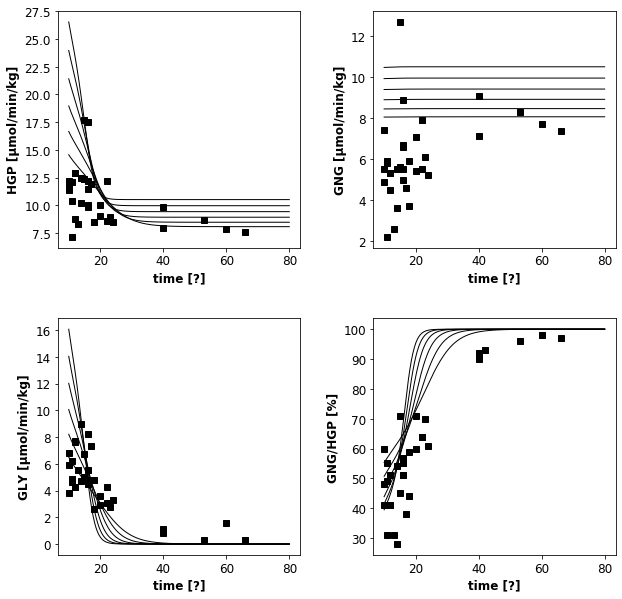

In [32]:
glc_ext_vec = np.linspace(3.6, 4.6, num=6)  # [mM]
print(glc_ext_vec)
results = []
for glc_ext in glc_ext_vec:
    r.resetToOrigin()
    r.setValue('init([glyglc])', 350)  # [mM]
    r.setValue('[glc_ext]', glc_ext)  # [mM]
    
    # presimulation
    r.simulate(0, 10, 2)
    # simulation
    s = r.simulate(0, 70*60, 300)
    s = pd.DataFrame(s, columns=s.colnames)
    results.append(s)
    
# full timecourse
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
f.subplots_adjust(wspace=.3, hspace=.3)
axes = (ax1, ax2, ax3, ax4)

for ax in axes:
    ax.set_xlabel('time [?]')
    
for s in results:
    time = s.time/60 +10  # +10
    ax1.plot(time, -s.HGP, color="black", linewidth=1.0)
    # ax1.set_ylim(0, 17)
    ax2.plot(time, -s.GNG, color="black", linewidth=1.0)
    # ax2.set_ylim(0, 12)
    ax3.plot(time, -s.GLY, color="black", linewidth=1.0)
    # ax3.set_ylim(0, 12)
    ax4.plot(time, s.GNG/s.HGP*100, color="black", linewidth=1.0)
    # ax4.set_ylim(0, 100)
    
ax1.set_ylabel('HGP [µmol/min/kg]')
ax2.set_ylabel('GNG [µmol/min/kg]')
ax3.set_ylabel('GLY [µmol/min/kg]')
ax4.set_ylabel('GNG/HGP [%]')

# add experimental data
Nuttal2008_TabA = load_glc_data("Nuttal2008_TabA", show=False)
data = Nuttal2008_TabA[Nuttal2008_TabA.condition == "normal"]
kwargs_points = {'linestyle': 'None', 'marker': 's', 'color': 'black'}
ax1.plot(data.time, data.hgp, **kwargs_points)
ax2.plot(data.time, data.gng, **kwargs_points)
ax3.plot(data.time, data.gly, **kwargs_points)
ax4.plot(data.time, data.gng_hgp, **kwargs_points)

f.savefig("./Output_Fig3.png", bbox_inches="tight", dpi=300)
plt.show()

Simulation time courses
(dashed lines) start at t = 10 h with glycogen partially filled glycogen stores (350 mM). Blood glucose is varied between 3.6 mM (red) and 4.6 mM
(green) in steps of 0.2 mM.


Image(url= "Koenig2012_Figure_3.png", width=500)

## Glycogen synthesis, glycogenolysis (Figure 4)

[3.6 3.8 4.  4.2 4.4 4.6 4.8 5. ]
[5.5 6.  6.5 7.  7.5 8. ]


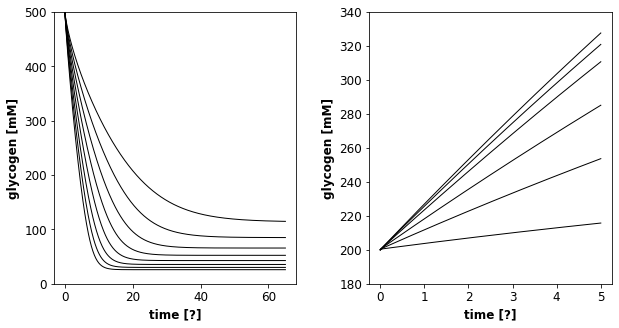

In [35]:
r.resetAll()
r.timeCourseSelections = ['time'] + ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()] + r.model.getReactionIds() + r.model.getGlobalParameterIds()

# ------------------
# glycogenolysis
# ------------------
glc_ext_GLY = np.linspace(3.6, 5.0, num=8)  # [mM]
print(glc_ext_GLY)
results_GLY = []
for glc_ext in glc_ext_GLY:
    r.resetToOrigin()
    r.setValue('init([glyglc])', 500)  # [mM]
    r.setValue('[glc_ext]', glc_ext)
    s = r.simulate(0, 65*60, 600)
    s = pd.DataFrame(s, columns=s.colnames)
    results_GLY.append(s)

# --------------------
# glycogen synthesis
# --------------------
glc_ext_GS = np.linspace(5.5, 8.0, num=6)  # [mM]
print(glc_ext_GS)
results_GS = []
for glc_ext in glc_ext_GS:
    r.resetToOrigin()
    r.setValue('init([glyglc])', 200)  # [mM]
    r.setValue('[glc_ext]', glc_ext)
    s = r.simulate(0, 300, 600)
    s = pd.DataFrame(s, columns=s.colnames)
    results_GS.append(s)

# --------------------
# figure
# --------------------
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))
f.subplots_adjust(wspace=.3, hspace=.3)
axes = (ax1, ax2)

for ax in axes:
    ax.set_xlabel('time [?]')
    ax.set_ylabel('glycogen [mM]')

for s in results_GLY:
    ax1.plot(s.time/60, s['[glyglc]'], color="black", linewidth=1.0)
    ax1.set_ylim(0, 500)

for s in results_GS:
    ax2.plot(s.time/60, s['[glyglc]'], color="black", linewidth=1.0)
    ax2.set_ylim(180, 340)

f.savefig("./Output_Fig4.png", bbox_inches="tight", dpi=300)
plt.show()

In [95]:
Image(url= "Koenig2012_Figure_4.png", width=500)

## Steady state HGP, GNG, GLY (Figure 5)
Set glycogen to a constant value

In [176]:
# necessary to modify model
import tesbml as libsbml
doc = libsbml.readSBMLFromFile("Hepatic_glucose_3.xml")
model = doc.getModel()

# set glycogen constant (boundary Condition)
s_glyglc = model.getSpecies('glyglc')
s_glyglc.setBoundaryCondition(True)
model.setId(model.getId() + "_const_glyglc")
model.setName(model.getName() + " const_glyglc")

model2 = libsbml.writeSBMLToString(doc)
r2 = te.loadSBMLModel(model2)
r2.timeCourseSelections = ['time'] + ["HGP", "GNG", "GLY"] + ['[glyglc]', '[glc_ext]']

['time', 'HGP', 'GNG', 'GLY', '[glyglc]', '[glc_ext]']


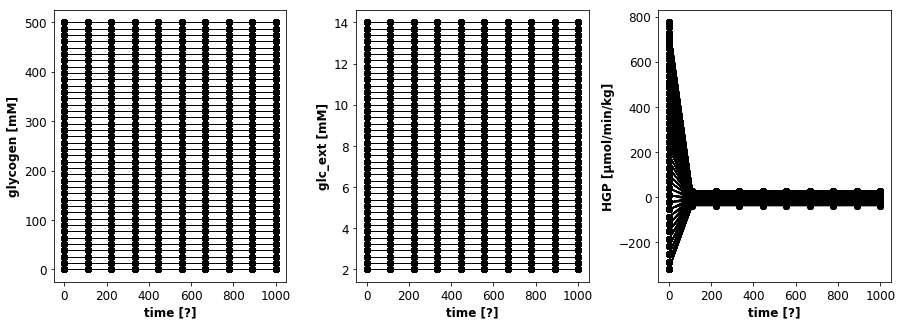

In [178]:
# simulate the grid of glucose and lactate concentrations
glc_ext_vec = np.linspace(2, 14, num=40)
glyglc_vec = np.linspace(0, 500, num=40)

HGP = np.zeros(shape=(glc_ext_vec.size, glyglc_vec.size))
GNG = np.zeros(shape=(glc_ext_vec.size, glyglc_vec.size))
GLY = np.zeros(shape=(glc_ext_vec.size, glyglc_vec.size))

print(r2.timeCourseSelections)
Nt = 10

results = []

for p, glc_ext in enumerate(glc_ext_vec):
    for q, glyglc in enumerate(glyglc_vec):
        r2.resetAll()
        r2.resetToOrigin()
        r2.setValue('[glyglc]', glyglc)  # [mM]
        r2.setValue('[glc_ext]', glc_ext)  # [mM]
        
        s = r2.simulate(0, 1000, Nt)
        s = pd.DataFrame(s, columns=s.colnames)
        HGP[p, q] = s.HGP[Nt-1]
        GNG[p, q] = s.GNG[Nt-1]
        GLY[p, q] = s.GLY[Nt-1]
        results.append(s)
        
# --------------------
# figure
# --------------------
if False:
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))
    f.subplots_adjust(wspace=.3, hspace=.3)
    axes = (ax1, ax2, ax3)

    for ax in axes:
        ax.set_xlabel('time [?]')
        # ax.set_ylabel('flux [µmol/kg/min]')

    for s in results:
        ax1.plot(s.time, s['[glyglc]'], '-o', color="black", linewidth=1.0)
        ax1.set_ylabel('glycogen [mM]')
        ax2.plot(s.time, s['[glc_ext]'], '-o', color="black", linewidth=1.0)
        ax2.set_ylabel('glc_ext [mM]')
        ax3.plot(s.time, s['HGP'], '-o', color="black", linewidth=1.0)
        ax3.set_ylabel('HGP [µmol/min/kg]')
    f.savefig("./Output_Fig5.png", bbox_inches="tight", dpi=300)

    plt.show()

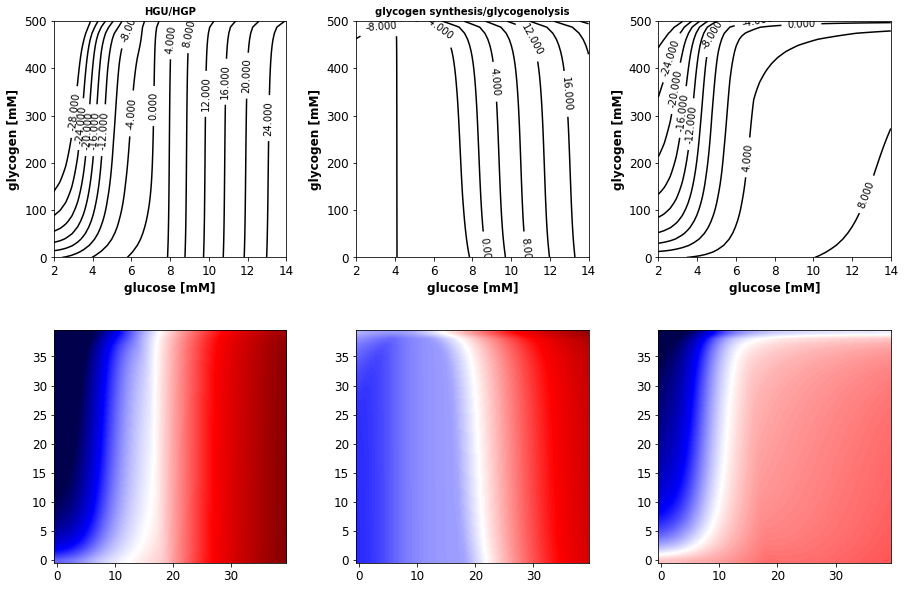

In [175]:
# plt.imshow(HGP, cmap='hot', interpolation='nearest')
import matplotlib
import matplotlib.cm as cm
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
f.subplots_adjust(hspace=0.3, wspace=0.3)
axes = (ax1, ax2, ax3, ax4, ax5, ax6)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('glucose [mM]')
    ax.set_ylabel('glycogen [mM]')

# HGP
ax1.set_title("HGU/HGP")
CS = ax1.contour(glc_ext_vec, glyglc_vec, (HGP.transpose()), np.linspace(-28, 28, num=15),
                 colors='k')
ax1.clabel(CS, inline=1, fontsize=10)
im = ax4.imshow(HGP.transpose(), interpolation='bilinear', cmap=cm.seismic, origin="lower", vmin=-28, vmax=28)

ax2.set_title("glycolysis/gluconeogenesis")
CS = ax2.contour(glc_ext_vec, glyglc_vec, (GNG.transpose()), np.linspace(-28, 28, num=15),
                 colors='k')
ax2.clabel(CS, inline=1, fontsize=10)
ax5.imshow(GNG.transpose(), interpolation='bilinear', cmap=cm.seismic, origin="lower", vmin=-28, vmax=28)

ax2.set_title("glycogen synthesis/glycogenolysis")
CS = ax3.contour(glc_ext_vec, glyglc_vec, (GLY.transpose()), np.linspace(-28, 28, num=15),
                 colors='k')
ax3.clabel(CS, inline=1, fontsize=10)
ax6.imshow(GLY.transpose(), interpolation='bilinear', cmap=cm.seismic, origin="lower", vmin=-28, vmax=28)

plt.show()

In [17]:
Image(url= "Koenig2012_Figure_5.png", width=500)